<a href="https://colab.research.google.com/github/SethJorissen/ANM_anomalies_project/blob/main/ANM_anomalies_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANM anomaly detection project - phase 2

Tsinghua 2023, produced by Aris Dressino and Seth Jorissen

## 1. initial set up

- fetch data for analysis
- import needed libraries

In [1]:
# fetch phase 1 and 2 data from github to colab working directory - run once
# consider using another method if working from local client
%%capture
#import shutil
#shutil.rmtree('/content/phase1')
!apt install subversion
!svn checkout https://github.com/SethJorissen/ANM_anomalies_project/trunk/phase1
!svn checkout https://github.com/SethJorissen/ANM_anomalies_project/trunk/phase2

In [2]:
# needed libraries
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
from tqdm import tqdm
from typing import Dict, List
from typing import List, Dict, Tuple, Set
from scipy.stats import pearsonr
import shutil

##2. Exploratory data analysis

- provide summary statistics and relevant analysis of the data
- plot relevant features of the dataset against timestamp



In [3]:
# import train set
# Set the path to the directory containing the CSV files
path = 'phase2/dataset/train/processed'

# Get a list of all CSV files in the directory
files = glob.glob(os.path.join(path, '*.csv'))

df_list = []
# Iterate over each file, read it into a DataFrame, and add a new column with the filename
for file in files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Add a new column with the filename without the extension
    filename = os.path.splitext(os.path.basename(file))[0]
    df['service'] = filename
    df_list.append(df)

# Concatenate all dataframes into a single dataframe
train = pd.concat(df_list, ignore_index=True)

train.head(5)

,timestamp,container_network_receive_packets_dropped.eth0,container_spec_cpu_shares,container_spec_memory_swap_limit_MB,container_fs_writes_MB./dev/vda,container_network_transmit_packets_dropped.eth0,container_network_receive_errors.eth0,container_fs_writes_merged./dev/vda1,container_threads_max,container_fs_write_seconds./dev/vda1,...,container_spec_cpu_period,container_memory_swap,container_threads,container_network_transmit_errors.eth0,container_spec_memory_limit_MB,container_fs_reads_merged./dev/vda1,container_network_transmit_MB.eth0,container_cpu_system_seconds,container_cpu_load_average_10s,service
0,1647619260,0.0,102.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,26.0,0.0,128.0,0.0,1.835316,0.00,0.0,checkoutservice2-0
1,1647619320,0.0,102.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,26.0,0.0,128.0,0.0,1.855980,0.01,0.0,checkoutservice2-0
2,1647619380,0.0,102.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,26.0,0.0,128.0,0.0,1.850951,0.00,0.0,checkoutservice2-0
3,1647619440,0.0,102.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,26.0,0.0,128.0,0.0,1.848471,0.01,0.0,checkoutservice2-0
4,1647619500,0.0,102.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,26.0,0.0,128.0,0.0,1.837285,0.00,0.0,checkoutservice2-0


In [4]:
# describe numerical metrics of train dataset
pd.set_option('display.max_columns', None)
train.describe()

,timestamp,container_network_receive_packets_dropped.eth0,container_spec_cpu_shares,container_spec_memory_swap_limit_MB,container_fs_writes_MB./dev/vda,container_network_transmit_packets_dropped.eth0,container_network_receive_errors.eth0,container_fs_writes_merged./dev/vda1,container_threads_max,container_fs_write_seconds./dev/vda1,container_fs_inodes_free./dev/vda1,container_fs_sector_reads./dev/vda1,container_network_transmit_packets.eth0,container_cpu_usage_seconds,container_cpu_cfs_throttled_periods,container_file_descriptors,container_cpu_cfs_throttled_seconds,container_fs_reads./dev/vda,container_fs_reads./dev/vda1,container_memory_failures.container.pgfault,container_memory_failures.container.pgmajfault,container_memory_failures.hierarchy.pgfault,container_memory_failures.hierarchy.pgmajfault,container_memory_max_usage_MB,container_fs_inodes./dev/vda1,container_fs_reads_MB./dev/vda,container_last_seen,container_cpu_user_seconds,container_fs_limit_MB./dev/vda1,container_fs_io_time_weighted_seconds./dev/vda1,container_fs_sector_writes./dev/vda1,container_network_receive_packets.eth0,container_memory_working_set_MB,container_fs_io_current./dev/vda1,container_memory_usage_MB,container_fs_usage_MB./dev/vda1,container_sockets,container_fs_io_time_seconds./dev/vda1,container_memory_failcnt,container_spec_cpu_quota,container_fs_writes./dev/vda,container_fs_writes./dev/vda1,container_ulimits_soft.max_open_files,container_network_receive_MB.eth0,container_tasks_state.iowaiting,container_tasks_state.running,container_tasks_state.sleeping,container_tasks_state.stopped,container_tasks_state.uninterruptible,container_fs_read_seconds./dev/vda1,container_memory_rss,container_start_time_seconds,container_memory_mapped_file,container_spec_memory_reservation_limit_MB,container_memory_cache,container_cpu_cfs_periods,container_spec_cpu_period,container_memory_swap,container_threads,container_network_transmit_errors.eth0,container_spec_memory_limit_MB,container_fs_reads_merged./dev/vda1,container_network_transmit_MB.eth0,container_cpu_system_seconds,container_cpu_load_average_10s
count,6.043800e+04,60438.0,57560.000000,57560.000000,57560.0,60438.0,60438.0,57560.0,57560.0,57560.0,57560.0,57560.0,60438.000000,57560.000000,57560.000000,57560.000000,57560.000000,57560.000000,57560.0,57560.000000,57560.000000,57560.000000,57560.000000,57560.000000,57560.000000,55160.000000,5.756000e+04,57560.000000,57560.000000,57560.0,57560.0,60438.000000,57560.000000,57560.0,57560.000000,57560.000000,57560.000000,57560.0,57560.000000,57560.000000,57560.0,57560.0,5.516000e+04,60438.000000,57560.0,57560.0,57560.0,57560.0,57560.0,57560.0,5.756000e+04,5.756000e+04,5.756000e+04,57560.0,5.756000e+04,57560.000000,57560.0,57560.0,57560.000000,60438.0,57560.000000,57560.0,60438.000000,57560.000000,57560.0
mean,1.647662e+09,0.0,206.700000,368.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,924.801215,0.206512,0.232922,36.786211,0.015082,0.092393,0.0,187.468016,0.017391,187.468016,0.017391,345.199549,0.000718,0.001766,1.647662e+09,0.119992,604630.738281,0.0,0.0,980.062690,64.047569,0.0,73.251540,83.679335,5.438988,0.0,0.750000,37000.000000,0.0,0.0,9.011200e+05,0.168638,0.0,0.0,0.0,0.0,0.0,0.0,4.827034e+07,1.647205e+09,4.181940e+06,0.0,1.566113e+07,113.878423,100000.0,0.0,25.588870,0.0,368.125000,0.0,1.341939,0.060221,0.0
std,2.492441e+04,0.0,95.695972,280.152678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1633.733856,0.260263,0.758866,48.356892,0.055175,5.503762,0.0,616.697959,1.403371,616.697959,1.403371,288.281897,0.046823,0.114247,2.492442e+04,0.132230,0.000000,0.0,0.0,1533.730644,53.881059,0.0,54.288065,160.741765,2.885062,0.0,2.576357,12884.210647,0.0,0.0,3.510187e+05,0.280004,0.0,0.0,0.0,0.0,0.0,0.0,5.436171e+07,1.479419e+05,5.950796e+06,0.0,7.325586e+06,97.499338,0.0,0.0,4.989798,0.0,280.152678,0.0,1.425130,0.100049,0.0
min,1.647619e+09,0.0,102.000000,128.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109.500000,0.000000,0.000000,7.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000

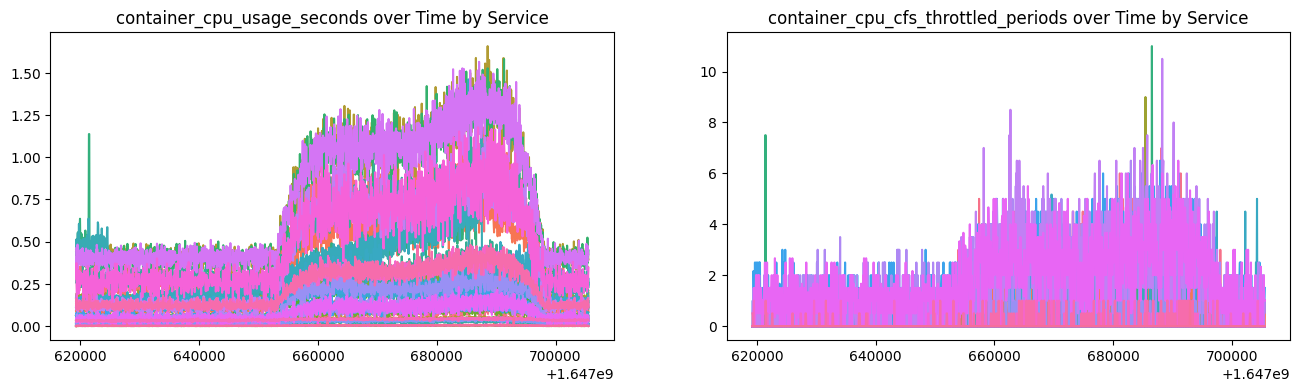

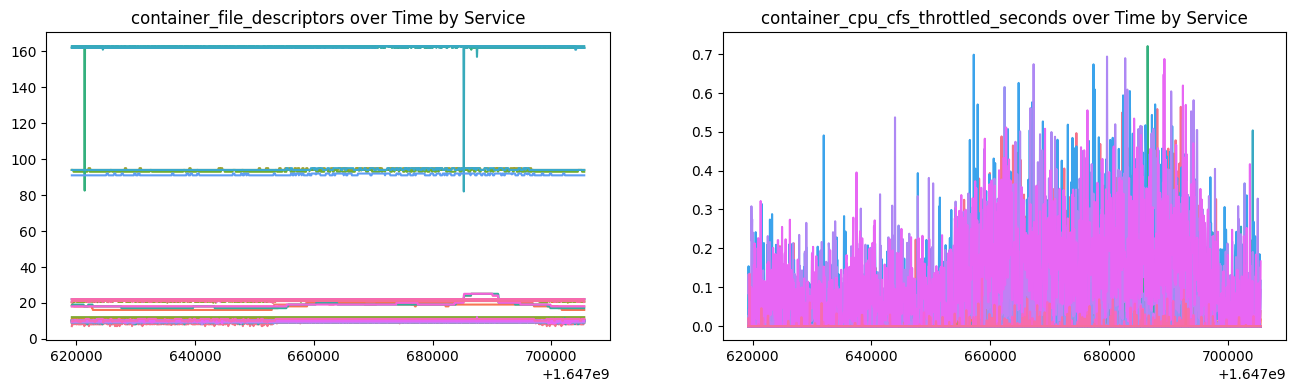

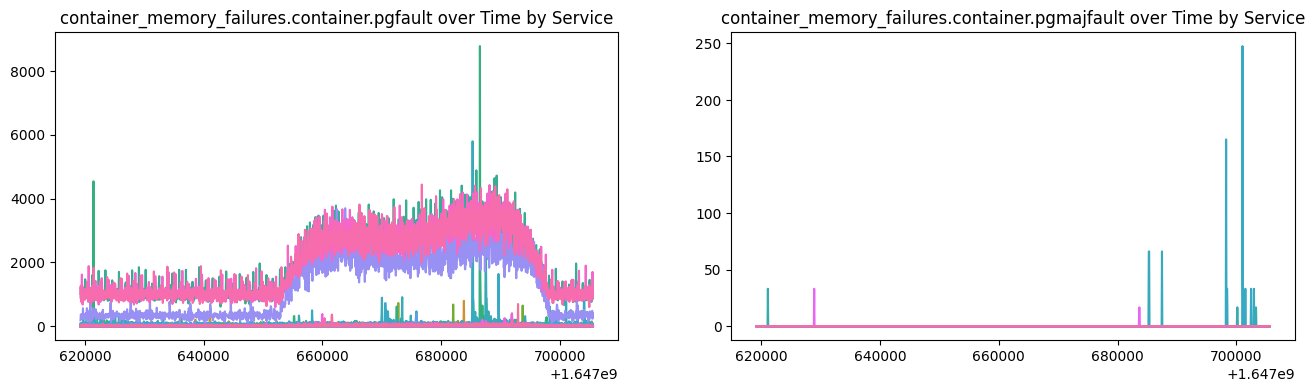

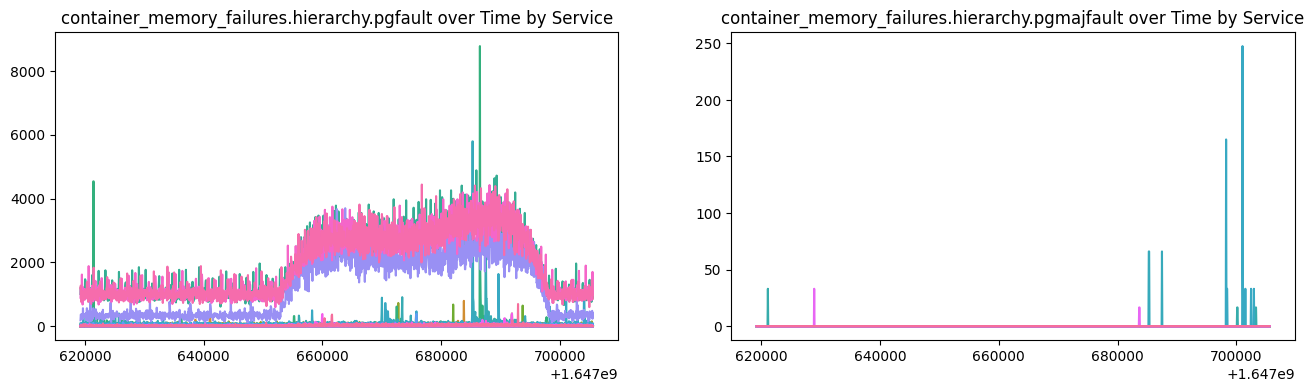

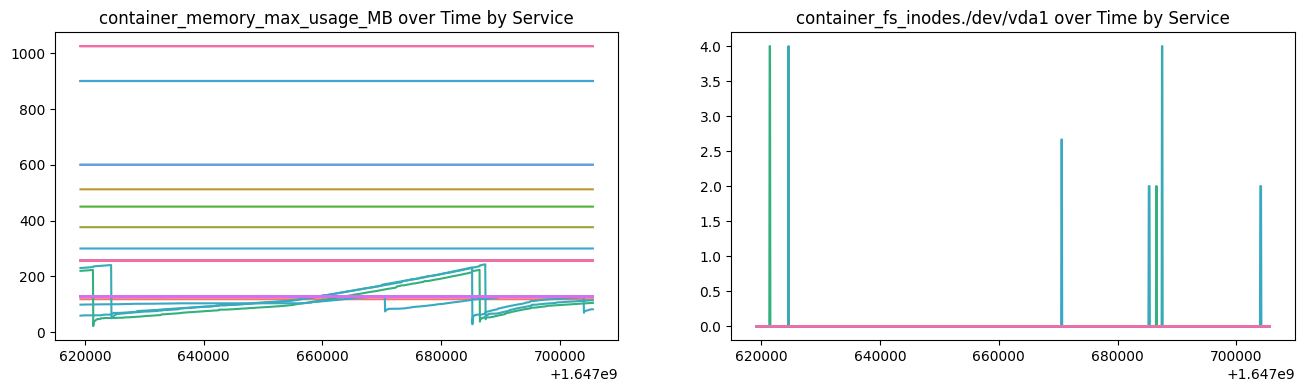

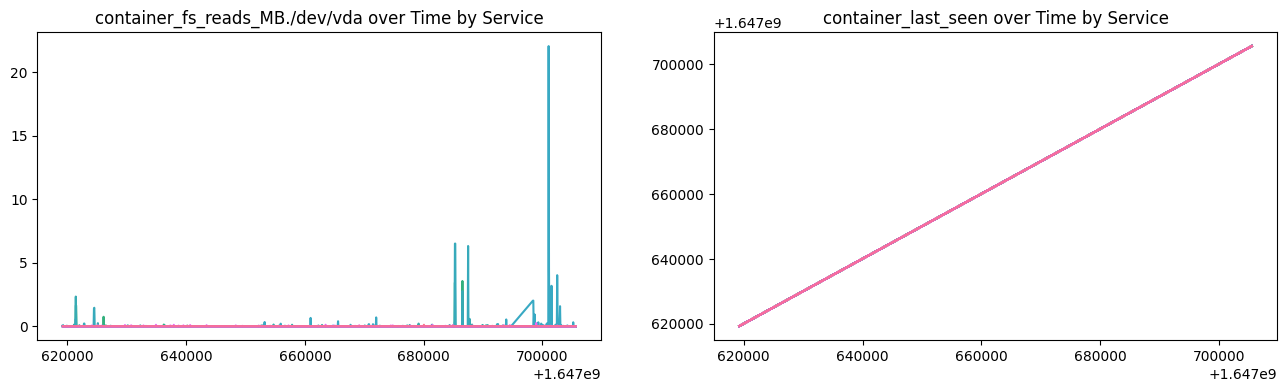

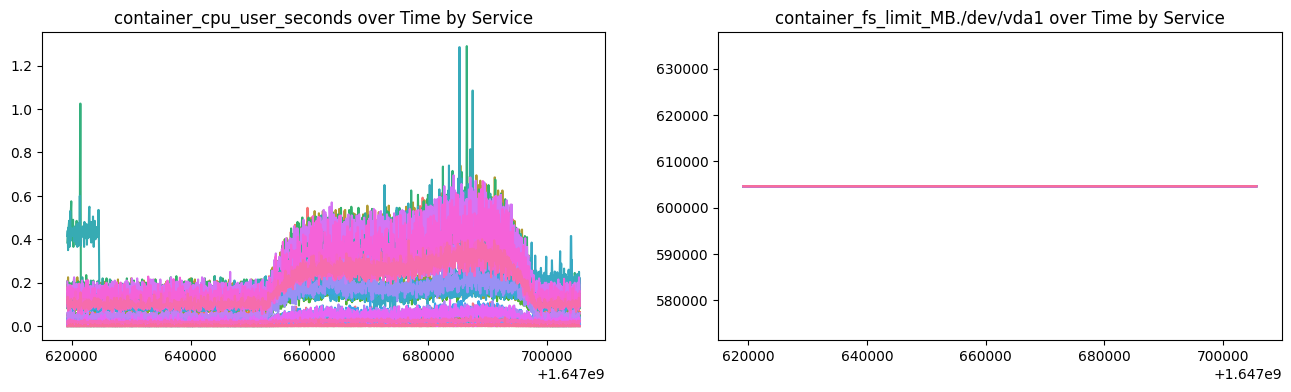

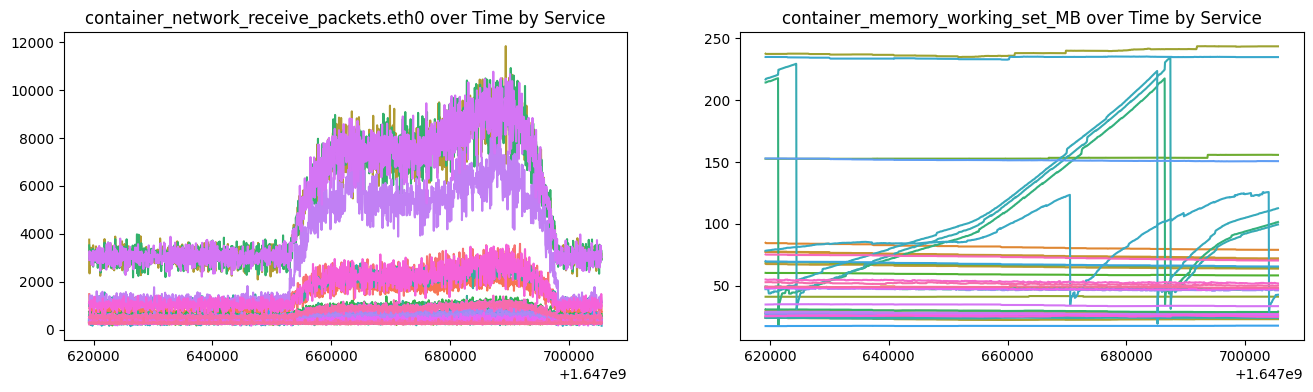

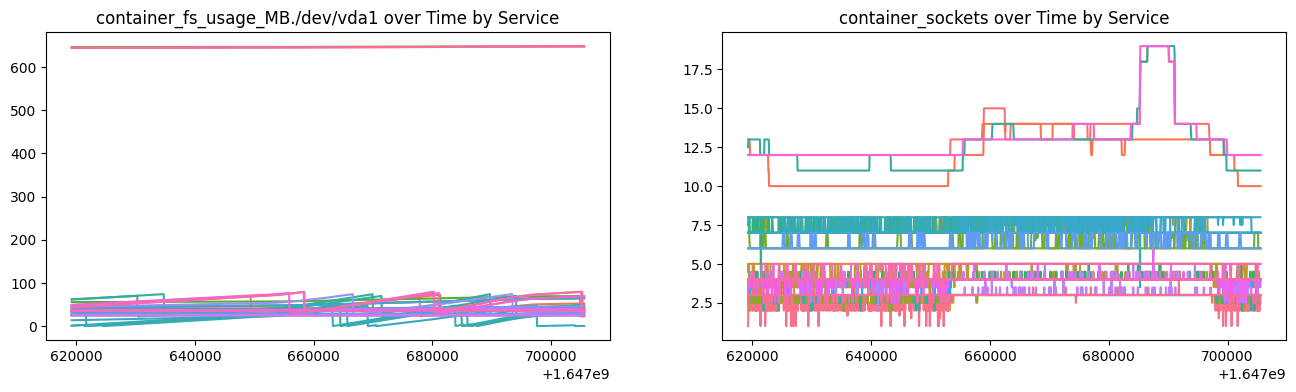

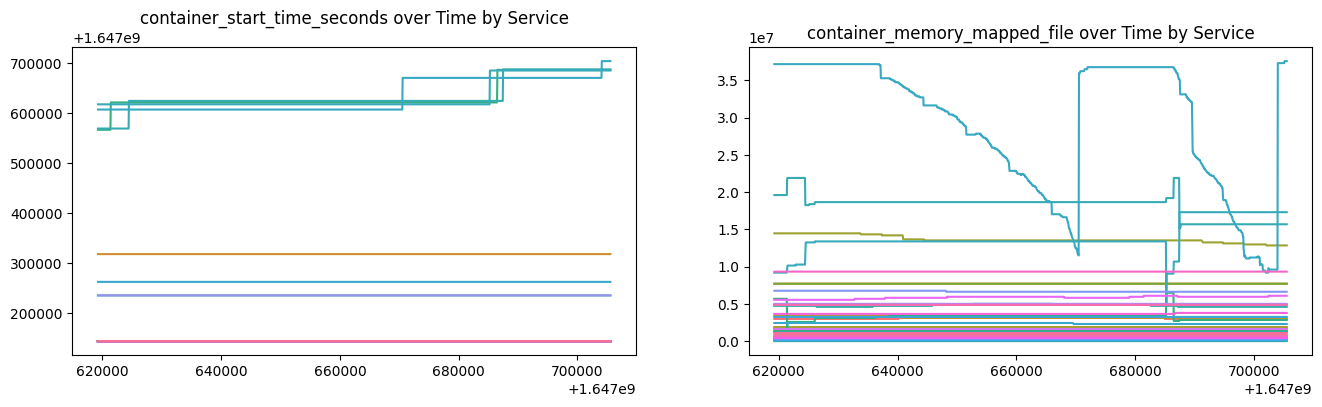

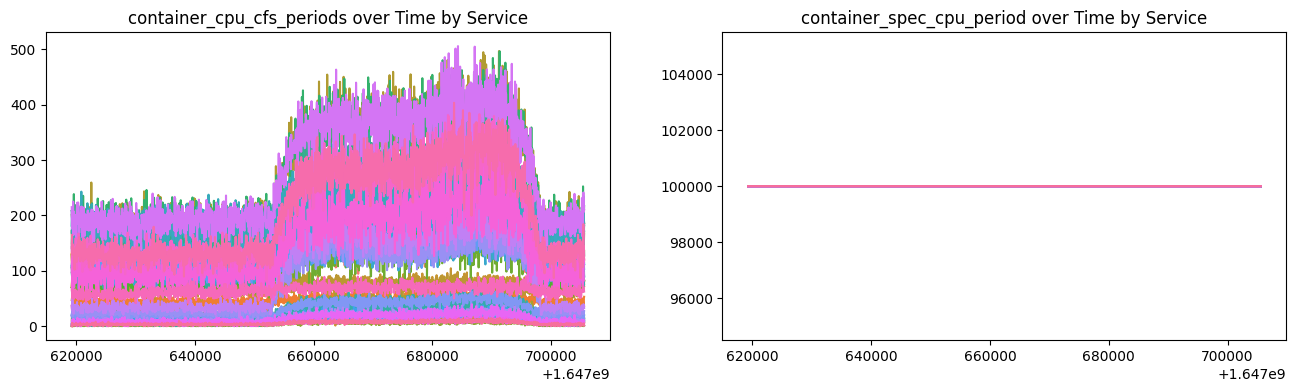

In [5]:
# Loop over all columns in the DataFrame except "timestamp" and "service"
cols = train.columns.drop(["timestamp", "service"])
for i in range(0, len(cols), 2):
    col1 = cols[i]
    col2 = cols[i+1] if i+1 < len(cols) else None

    # Check if all values in the column are 0 or the same value
    if (len(train[col1].unique()) == 1 or train[col1].sum() == 0) or (not col2 or (len(train[col2].unique()) == 1 or train[col2].sum() == 0)):
        continue

    # Check if the values are equal when grouped by service for both columns
    if col2:
        grouped1 = train.groupby('service')[col1].nunique()
        grouped2 = train.groupby('service')[col2].nunique()
        if len(grouped1.unique()) == 1 or len(grouped2.unique()) == 1:
            continue
        
    # Create a new row of subplots with 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    # Create the first plot in the left column
    sns.lineplot(x="timestamp", y=col1, hue="service", data=train, ax=axs[0])
    axs[0].set_title(f"{col1} over Time by Service")

    # Remove the legend from the first plot
    axs[0].get_legend().remove()

    # Create the second plot in the right column if there is a second column
    if col2:
        sns.lineplot(x="timestamp", y=col2, hue="service", data=train, ax=axs[1])
        axs[1].set_title(f"{col2} over Time by Service")

        # Remove the legend from the second plot
        axs[1].get_legend().remove()

    # Remove axis labels from all subplots
    for ax in axs:
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Set the height of all subplots to the same value
    fig.subplots_adjust(hspace=0.4)

    # Add a border to the row of subplots
    for ax in axs:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

    # Show the row of subplots
    plt.show()



##3. Anomaly Localization

This model first creates an anomaly detection model for all microservices using a LSTM AE. This model will return a series of anomaly scores over time and a boolean which indicates whether the threshold was breached.

Then a root cause analasis starts. The edges and nodes of the topology graph will be given weights. The nodes of this graph will be ranked by PageRank.

###3.1 Data management

This class will prepare the data in the test/train folders. Given a folder it will load all csv files and and put them in a dictionary with their name as key. It gets rid of NaN values and removes irrelavent columns.

In [83]:
import os
import pandas as pd
import numpy as np

class DataManager:
    def __init__(self, data_path: str, train: bool = False, ignore_columns=None):
        if ignore_columns is None:
            ignore_columns = [
                'timestamp',
                'container_start_time_seconds',
                'container_last_seen']
        self.data_path = data_path
        self.ignore_columns = ignore_columns
        self.train = train

        # Load from file
        self.data = {}
        self.columns = []
        self.__load()

    def __fill_na(self, df: pd.DataFrame):
        if self.train:
            df.interpolate(method='linear', inplace=True)
        df.fillna(0.0, inplace=True)

    def __normalize_data(self, data: np.ndarray):
        # Subtract the mean from each column
        mean = np.mean(data, axis=0)
        normalized_data = data - mean

        return normalized_data

    def __load(self):
        for file in os.listdir(self.data_path):
            if not file.endswith('.csv'):
                continue

            cur_df = pd.read_csv(os.path.join(self.data_path, file), engine='c')
            self.__fill_na(cur_df)
            self.columns = sorted([i for i in cur_df.columns.values if i not in self.ignore_columns])
            raw_data = cur_df[self.columns].values

            # Normalize the data to have the same mean distribution
            normalized_data = self.__normalize_data(raw_data)

            self.data[file[:-4]] = normalized_data

    def get(self, s: str) -> np.ndarray:
        return self.data[s]


###3.2 Anomaly detection

The anomaly detection model uses two classes:
- $LSTMAEDetector$ holds a LSTM AE to detect anomolies in a microservice. Before fitting the model, it first prepares the input data by scaling and creating sequences. Then it defines the model and fits it on the data. Finally the loss is scaled so all microservices can use the same threshold. To make a prediction, the data is prepared the same way and the scaled reconstruction loss of the model is calculated. This will be the anomaly score. All the anomaly scores will be returned and it will also check whether the threshold was breached at any point.

- The anomaly detector class will create and fit the LSTM AE Detectors of all microservices. When detecting an anomoly, it will call the detector of all microservices and return whether they encountered an anomaly and their anomaly scores.





In [138]:
# GRAPH BASED DETECTOR

from sklearn.neighbors import LocalOutlierFactor

class GraphBasedDetector:
    def __init__(self):
        self.detector = None

    def fit(self, data: np.ndarray):
        self.detector = LocalOutlierFactor(contamination='auto')
        self.detector.fit(data)

    def decision_function(self, data: np.ndarray):
        # Data: [timesteps x features]
        scores = self.detector.negative_outlier_factor_
        anomaly_scores = np.ones_like(scores) - (1 + scores) / 2
        return anomaly_scores

class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, Any] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = GraphBasedDetector()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def decision_function(self, data: np.ndarray):
        anomaly_scores = {}

        for k, v in data.data.items():
            detector = self.detector_dict[k]
            scores = detector.decision_function(v)
            anomaly_scores[k] = scores

        return anomaly_scores

    def detect(self, data: DataManager):
        result = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)
            assert isinstance(detect_result, np.ndarray)
            result[k] = np.mean(detect_result)

        return result


    def detect(self, data: DataManager):
        # Simply return the max anomaly degree of all metrics
        result: Dict[str, float] = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)

            assert type(detect_result) == np.ndarray
            result[k] = np.mean(detect_result)

        return result


In [135]:
class KSigmaDetector:
    def __init__(self):
        pass

    def fit(self, data: np.ndarray):
        self.mu = np.mean(data, axis=0, keepdims=True)
        self.sigma = np.std(data, axis=0, keepdims=True)

    def decision_function(self, data: np.ndarray):
        # Data: [timesteps x features]
        scores = self.detector.negative_outlier_factor_
        anomaly_scores = np.ones_like(scores) - (1 + scores) / 2
        return anomaly_scores

class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, KSigmaDetecor] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = KSigmaDetecor()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def detect(self, data: DataManager):
        # Simply return the max anomaly degree of all metrics
        result: Dict[str, float] = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)

            assert type(detect_result) == np.ndarray
            result[k] = np.max(detect_result)

        return result

###3.3 Root cause localization
The root cause localization will rank all microservices based on the probability that they are the root cause of the anomaly. The ranker has to be initialized with an anomalydetector. To start ranking the microservices their anomaly scores are calculated. Afterwards, the algorithm will use following scoring formula to perform a simplified version of pagerank:

$$v_{t+1} = (1 - c)Pv_t + cu$$

where $v$ holds the score of all nodes, $P$ is a matrix holding the weights of all edges and $u$ is a vector with for each microservice, the max anomaly score. For all edges in the topology, $P$ is equal to the pearson correlation of the nodes it connects and 0 for all other edges. This means that the score for the nodes $v$ is parially defined by the anomaly score of the microservice and partially by the score of their parent nodes. However, that depends on the corralation between their anomaly scores.

This algrorithm is based on the MicroRCA algorithm, but we do not have all the data they had.

Li Wu, Johan Tordsson, Erik Elmroth, Odej Kao. MicroRCA: Root Cause Localization of Performance
Issues in Microservices. IEEE/IFIP Network Operations and Management Symposium (NOMS), Apr
2020, Budapest, Hungary. ffhal-02441640f

https://inria.hal.science/hal-02441640

In [126]:
# NORMALIZED SCORE SORTING

def find_correlation(container1: np.ndarray, container2: np.ndarray):
    corr = []
    for i in range(container1.shape[1]):
        if not np.all(container1[:, i] == container1[0, i]) and not np.all(container2[:, i] == container1[0, i]):
              corr.append(abs(pearsonr(container1[:, i].flatten(), container1[:, i].flatten())[0]))
    return sum(corr)/len(corr)

from scipy.stats import rankdata

class Ranker:
    """
    This is a naive ranking algorithm, which simply ranks according to the anomaly scores.
    """
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.train_data = DataManager(hyper_params['train_dir'])
        self.anomaly_detector = AnomalyDetector(hyper_params)
        self._init_ranker()

    def _init_ranker(self):
        self.anomaly_detector.fit(self.train_data)

    def rank(self, case_dir: str):
        # Load test data
        test_data = DataManager(case_dir)

        # Detect anomaly
        anomaly_score = self.anomaly_detector.detect(test_data)
        print(anomaly_score)

        # Normalize anomaly scores
        scores = np.array(list(anomaly_score.values()))
        normalized_scores = (scores - np.min(scores)) / (np.max(scores) - np.min(scores) + 1e-8)

        # Obtain ranks
        ranks = rankdata(-normalized_scores, method='min')

        # Sort the ranks in ascending order and get the corresponding keys
        rank_result = [k for _, k in sorted(zip(ranks, anomaly_score.keys()))]

        # Sort the containers based on normalized scores
        rank_result = sorted(list(anomaly_score.keys()), key=lambda x: normalized_scores[list(anomaly_score.keys()).index(x)], reverse=True)

        return rank_result


###3.4 Training

In [139]:
"""
hyper_params = {
    'train_dir': 'phase2/dataset/train/processed',
    'test_dir': 'phase2/dataset/test/processed',
    'label_path': 'phase2/dataset/test/label.json',
    'topology': 'phase1/dataset/topology/service_topology.json'
}
"""
hyper_params = {
    'train_dir': 'phase1/dataset/train/processed',
    'test_dir': 'phase1/dataset/test/processed',
    'label_path': 'phase1/dataset/test/label.json',
    'topology': 'phase1/dataset/topology/service_topology.json'
}



ranker = Ranker(hyper_params)

Fitting detector(s): 100%|██████████| 42/42 [00:01<00:00, 22.98it/s]


##4. evaluation, prediction and metrics

- evaluate test set anomalies and rank them
- compare labels with predicted ranking
- information regarding indexing are provided

In [14]:
class Evaluator:
    """
        Evaluate the localization algorithm with the give label.
    """
    def __init__(self, label_path: str):
        self.label_path = label_path

        with open(self.label_path, 'rt') as f:
            self.label = json.load(f)

    def evaluate(self, detect_results: List[List[str]], topk: List[int] = [1, 10, 20], write_report: bool=False):
        """
            Input: List of cases. Each case is a ranked list of root causes from the most likely ones to the least likely ones.
            Print the evaluation result.
        """
        all_ranks: List[int] = []
        topk_hit: List[List[int]] = []

        for i, case in enumerate(detect_results):
            cur_label = self.label['cmdb_id'][i]

            # Cur_rank is the rank of current case. Default is length of the list + 1.
            cur_rank = len(case) + 1
            for rank, root_cause in enumerate(case):
                if cur_label in root_cause:
                    cur_rank = rank + 1
                    break
            
            all_ranks.append(cur_rank)
            
            # Calculate the topk hit for current case.
            cur_topk_hit = []
            for k in topk:
                if cur_rank <= k:
                    cur_topk_hit.append(1)
                else:
                    cur_topk_hit.append(0)
            topk_hit.append(cur_topk_hit)

            # Write report if true
            if write_report:
                os.makedirs("report", exist_ok=True)
                report_content = f"Label: {cur_label}\n========List=======\n"
                for rank, root_cause in enumerate(case):
                    report_content += f"{rank}: {root_cause}\n"
                    if cur_label in root_cause:
                        report_content += "^ ROOT CAUSE\n"
                with open(os.path.join("report", f"{i}.txt"), "wt") as f:
                    f.write(report_content)

        # Calculate the average results
        mrr = np.mean(1 / np.array(all_ranks))
        avg_topk_hit = np.mean(topk_hit, axis=0)

        # Report the result
        report: str = "--------------Report-------------\n"
        for i in range(len(all_ranks)):
            report += f"Case {i}: "
            for j, k in enumerate(topk):
                report += f"Top {k}: {topk_hit[i][j]}\t"
            report += f"Rank: {all_ranks[i]}\n"

        report += "============AVG=============="
        for j, k in enumerate(topk):
            report += f"Top {k}: {avg_topk_hit[j]:.4f}, "
        report += f"MRR: {mrr:.4f}"
        print(report)

In [102]:
# Generate a list of lists containing the labels for the test set of phase 1 only
# Load the JSON file
with open('phase1/dataset/test/label.json', 'r') as json_file:
    data = json.load(json_file)

df_labels = pd.DataFrame(data)
labels = df_labels.values.tolist()

print(labels)

[[1648486942, 'emailservice-0'], [1648491433, 'recommendationservice2-0'], [1648492533, 'currencyservice-1'], [1648507813, 'paymentservice-1'], [1648512399, 'productcatalogservice-0'], [1648518075, 'shippingservice2-0'], [1648520175, 'productcatalogservice-0'], [1648522456, 'paymentservice-0'], [1648525065, 'frontend2-0'], [1648540678, 'shippingservice-2'], [1648541744, 'frontend2-0'], [1648552790, 'adservice2-0'], [1648558337, 'recommendationservice-2'], [1648560649, 'cartservice-2'], [1648561519, 'emailservice-2'], [1648565706, 'frontend2-0'], [1648550137, 'cartservice-1'], [1648525567, 'cartservice-1'], [1648491097, 'paymentservice-2'], [1648494319, 'adservice-2'], [1648506344, 'productcatalogservice-1'], [1648516367, 'productcatalogservice-0'], [1648528148, 'recommendationservice-1'], [1648528984, 'shippingservice-2'], [1648531433, 'cartservice-2'], [1648540897, 'shippingservice-2'], [1648549152, 'emailservice-2'], [1648551076, 'shippingservice-2'], [1648552118, 'recommendationserv

In [140]:
result_list = []
case_idx: int = 0
with tqdm(total=len(os.listdir(hyper_params['test_dir']))) as t:
    while True:
        case_dir = os.path.join(hyper_params['test_dir'], str(case_idx))
        if not os.path.exists(case_dir):
            break
        t.set_description(f"Ranking {case_dir}")

        cur_rank = ranker.rank(case_dir)
        print("")
        print("the anomaly label is: ", labels[case_idx])
        print(cur_rank)
        for l in cur_rank:
          if l == labels[case_idx][1]:
            print("in the current rank, the original amonaly is in position ", cur_rank.index(l))
            break
        print("\n")
        result_list.append(cur_rank)

        # Update tqdm
        t.update()
        case_idx += 1

evaluator = Evaluator(hyper_params['label_path'])

evaluator.evaluate(result_list)

Ranking phase1/dataset/test/processed/1:   1%|          | 1/92 [00:00<00:21,  4.32it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/2:   2%|▏         | 2/92 [00:00<00:21,  4.16it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/3:   3%|▎         | 3/92 [00:00<00:21,  4.14it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/4:   4%|▍         | 4/92 [00:00<00:21,  4.18it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/5:   5%|▌         | 5/92 [00:01<00:20,  4.21it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/6:   7%|▋         | 6/92 [00:01<00:20,  4.22it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/7:   8%|▊         | 7/92 [00:01<00:19,  4.30it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/8:   9%|▊         | 8/92 [00:01<00:19,  4.27it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/9:  10%|▉         | 9/92 [00:02<00:22,  3.66it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/10:  11%|█         | 10/92 [00:02<00:25,  3.28it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/11:  12%|█▏        | 11/92 [00:02<00:25,  3.12it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/12:  13%|█▎        | 12/92 [00:03<00:26,  3.01it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/13:  14%|█▍        | 13/92 [00:03<00:26,  2.93it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/14:  15%|█▌        | 14/92 [00:04<00:26,  2.89it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/15:  16%|█▋        | 15/92 [00:04<00:27,  2.82it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/16:  17%|█▋        | 16/92 [00:04<00:26,  2.83it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/17:  18%|█▊        | 17/92 [00:05<00:24,  3.12it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/18:  20%|█▉        | 18/92 [00:05<00:21,  3.42it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/19:  21%|██        | 19/92 [00:05<00:20,  3.63it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/20:  22%|██▏       | 20/92 [00:05<00:18,  3.80it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/21:  23%|██▎       | 21/92 [00:05<00:18,  3.89it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/22:  24%|██▍       | 22/92 [00:06<00:17,  4.00it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/23:  25%|██▌       | 23/92 [00:06<00:16,  4.06it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/24:  26%|██▌       | 24/92 [00:06<00:16,  4.07it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/25:  27%|██▋       | 25/92 [00:06<00:16,  4.11it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/26:  28%|██▊       | 26/92 [00:07<00:15,  4.14it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/27:  29%|██▉       | 27/92 [00:07<00:15,  4.15it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/28:  30%|███       | 28/92 [00:07<00:15,  4.11it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/29:  32%|███▏      | 29/92 [00:07<00:15,  4.15it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/30:  33%|███▎      | 30/92 [00:08<00:15,  4.06it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/31:  34%|███▎      | 31/92 [00:08<00:14,  4.16it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/32:  35%|███▍      | 32/92 [00:08<00:14,  4.20it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/33:  36%|███▌      | 33/92 [00:08<00:14,  4.21it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/34:  37%|███▋      | 34/92 [00:09<00:13,  4.23it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/35:  38%|███▊      | 35/92 [00:09<00:13,  4.21it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/36:  39%|███▉      | 36/92 [00:09<00:13,  4.21it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/37:  40%|████      | 37/92 [00:09<00:12,  4.25it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/38:  41%|████▏     | 38/92 [00:10<00:13,  4.11it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/39:  42%|████▏     | 39/92 [00:10<00:12,  4.13it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/40:  43%|████▎     | 40/92 [00:10<00:12,  4.15it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/41:  45%|████▍     | 41/92 [00:10<00:12,  4.23it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/42:  46%|████▌     | 42/92 [00:10<00:11,  4.22it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/43:  47%|████▋     | 43/92 [00:11<00:11,  4.14it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/44:  48%|████▊     | 44/92 [00:11<00:11,  4.09it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/45:  49%|████▉     | 45/92 [00:11<00:11,  4.14it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/46:  50%|█████     | 46/92 [00:11<00:10,  4.23it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/47:  51%|█████     | 47/92 [00:12<00:10,  4.13it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/48:  52%|█████▏    | 48/92 [00:12<00:10,  4.05it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/49:  53%|█████▎    | 49/92 [00:12<00:10,  4.04it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/50:  54%|█████▍    | 50/92 [00:12<00:10,  4.10it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/51:  55%|█████▌    | 51/92 [00:13<00:10,  4.06it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/52:  57%|█████▋    | 52/92 [00:13<00:09,  4.10it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/53:  58%|█████▊    | 53/92 [00:13<00:09,  4.11it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/54:  59%|█████▊    | 54/92 [00:13<00:09,  4.13it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/55:  60%|█████▉    | 55/92 [00:14<00:09,  3.99it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/56:  61%|██████    | 56/92 [00:14<00:09,  3.95it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/57:  62%|██████▏   | 57/92 [00:14<00:08,  4.05it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/58:  63%|██████▎   | 58/92 [00:14<00:08,  3.91it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/59:  64%|██████▍   | 59/92 [00:15<00:09,  3.40it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/60:  65%|██████▌   | 60/92 [00:15<00:10,  3.14it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/61:  66%|██████▋   | 61/92 [00:16<00:10,  3.05it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/62:  67%|██████▋   | 62/92 [00:16<00:10,  2.99it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/63:  68%|██████▊   | 63/92 [00:16<00:10,  2.90it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/64:  70%|██████▉   | 64/92 [00:17<00:09,  2.89it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/65:  71%|███████   | 65/92 [00:17<00:09,  2.74it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/66:  72%|███████▏  | 66/92 [00:17<00:09,  2.72it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/67:  73%|███████▎  | 67/92 [00:18<00:09,  2.68it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/68:  74%|███████▍  | 68/92 [00:18<00:09,  2.63it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/69:  75%|███████▌  | 69/92 [00:19<00:08,  2.65it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/70:  76%|███████▌  | 70/92 [00:19<00:08,  2.59it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/71:  77%|███████▋  | 71/92 [00:19<00:07,  2.63it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/72:  78%|███████▊  | 72/92 [00:20<00:07,  2.66it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/73:  79%|███████▉  | 73/92 [00:20<00:07,  2.65it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/74:  80%|████████  | 74/92 [00:20<00:06,  2.71it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/75:  82%|████████▏ | 75/92 [00:21<00:05,  3.07it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/76:  83%|████████▎ | 76/92 [00:21<00:04,  3.35it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/77:  84%|████████▎ | 77/92 [00:21<00:04,  3.51it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/78:  85%|████████▍ | 78/92 [00:21<00:03,  3.73it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/79:  86%|████████▌ | 79/92 [00:22<00:03,  3.81it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/80:  87%|████████▋ | 80/92 [00:22<00:03,  3.92it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/81:  88%|████████▊ | 81/92 [00:22<00:02,  3.86it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/82:  89%|████████▉ | 82/92 [00:22<00:02,  3.98it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/83:  90%|█████████ | 83/92 [00:23<00:02,  4.04it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/84:  91%|█████████▏| 84/92 [00:23<00:01,  4.11it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/85:  92%|█████████▏| 85/92 [00:23<00:01,  4.07it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/86:  93%|█████████▎| 86/92 [00:23<00:01,  4.15it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/87:  95%|█████████▍| 87/92 [00:24<00:01,  4.20it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/88:  96%|█████████▌| 88/92 [00:24<00:00,  4.23it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/89:  97%|█████████▋| 89/92 [00:24<00:00,  4.13it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/90:  98%|█████████▊| 90/92 [00:24<00:00,  4.06it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/91:  99%|█████████▉| 91/92 [00:25<00:00,  4.09it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

Ranking phase1/dataset/test/processed/91: 100%|██████████| 92/92 [00:25<00:00,  3.64it/s]

{'checkoutservice2-0': 39.15898696595847, 'frontend-2': 6.5038453349811265, 'frontend2-0': 6.930349058692394, 'emailservice-0': 94.5943365176731, 'recommendationservice-1': 41.94530144073235, 'paymentservice-2': 24.139963339361667, 'emailservice-2': 86.85078836041757, 'emailservice2-0': 70.71398228607026, 'productcatalogservice-1': 3.332773561294694, 'shippingservice-0': 30.14969570402868, 'adservice-0': 58.557134032575135, 'paymentservice2-0': 2.542757054219927, 'recommendationservice-2': 50.72405475679071, 'adservice-2': 12.001165107363759, 'recommendationservice2-0': 22.198241527406168, 'redis-cart-0': 1.0701020460735373, 'productcatalogservice-0': 3.0293072787785653, 'cartservice-2': 1.0440912517190457, 'redis-cart2-0': 1.0608746171870864, 'currencyservice-2': 1.1605833136343509, 'frontend-0': 8.664171873428643, 'shippingservice2-0': 26.341752921814987, 'shippingservice-2': 51.57415775392334, 'cartservice-0': 1.0176090971162608, 'cartservice-1': 1.03047529162923, 'cartservice2-0': 

In [56]:
# Convert result_list to JSON format
json_result = json.dumps(result_list)

# Write ranked list to JSON file
with open('result_list.json', 'w') as file:
    file.write(json_result)